<a href="https://colab.research.google.com/github/efsiul/fruit_sorter_project/blob/master/Luis_Cadavid_Johana_Rios_DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install tensorflow

# DenseNet121
 CNN que es parte de la familia DenseNet (Densely Connected Convolutional Networks). La idea principal detrás de DenseNet es que cada capa está conectada a todas las demás capas de una manera densa. Esto significa que cada capa recibe como entrada no solo las salidas de la capa anterior, sino también todas las salidas de las capas anteriores.

La ventaja de este enfoque es que permite una mayor reutilización de características, lo que puede mejorar la eficiencia y el rendimiento del modelo. DenseNet121 es una variante de DenseNet que tiene 121 capas

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [ ]:
# Cargar el modelo base de DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Crear entradas con la forma correcta
inputs = Input(shape=(224, 224, 3))


29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
# Pasar las entradas a través del modelo base
x = base_model(inputs, training=False)

# Añadir una capa de pooling global
x = layers.GlobalAveragePooling2D()(x)

# Añadir la capa densa final
outputs = layers.Dense(6, activation='softmax')(x)

# Combinar entradas y salidas para crear el modelo
model = models.Model(inputs, outputs)


In [ ]:
# Mostrar el resumen del modelo
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 6)                 6150      
                                                                 
Total params: 7043654 (26.87 MB)
Trainable params: 6150 (24.02 KB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


In [ ]:
# Compilar el modelo
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
# Configurar los generadores de datos
datagen_train = ImageDataGenerator(samplewise_center=True,  # normalizar
    rotation_range=10,  # rotar aleatoriamente
    zoom_range=0.1,  # hacer zoom aleatoriamente
    width_shift_range=0.1,  # desplazar horizontalmente
    height_shift_range=0.1,  # desplazar verticalmente
    horizontal_flip=True,  # voltear horizontalmente
    vertical_flip=True)  # voltear verticalmente

datagen_valid = ImageDataGenerator(samplewise_center=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cargar y iterar sobre el conjunto de datos de entrenamiento
train_it = datagen_train.flow_from_directory(
    '/content/drive/MyDrive/Udea/Simulación/train',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
)

# Cargar y iterar sobre el conjunto de datos de validación
valid_it = datagen_valid.flow_from_directory(
    '/content/drive/MyDrive/Udea/Simulación/test',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    shuffle=False  # Asegurar que el orden de las imágenes sea el mismo para predicciones y etiquetas
)


Found 9833 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [ ]:
# Entrenar el modelo
model.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=train_it.samples // train_it.batch_size,
          validation_steps=valid_it.samples // valid_it.batch_size,
          epochs=20)


Epoch 1/20
307/307 [==============================] - 2677s 9s/step - loss: 1.8177 - categorical_accuracy: 0.6049 - val_loss: 1.0058 - val_categorical_accuracy: 0.7321
Epoch 2/20
307/307 [==============================] - 277s 902ms/step - loss: 0.9917 - categorical_accuracy: 0.7492 - val_loss: 0.7901 - val_categorical_accuracy: 0.7760
Epoch 3/20
307/307 [==============================] - 273s 887ms/step - loss: 0.8751 - categorical_accuracy: 0.7782 - val_loss: 0.6608 - val_categorical_accuracy: 0.8051
Epoch 4/20
307/307 [==============================] - 271s 881ms/step - loss: 0.7903 - categorical_accuracy: 0.7946 - val_loss: 0.4936 - val_categorical_accuracy: 0.8304
Epoch 5/20
307/307 [==============================] - 268s 871ms/step - loss: 0.7361 - categorical_accuracy: 0.8062 - val_loss: 0.6591 - val_categorical_accuracy: 0.7984
Epoch 6/20
307/307 [==============================] - 265s 864ms/step - loss: 0.7306 - categorical_accuracy: 0.8110 - val_loss: 0.6017 - val_categorical

In [ ]:
# Evaluar el modelo
model.evaluate(valid_it, steps=valid_it.samples // valid_it.batch_size)

84/84 [==============================] - 45s 531ms/step - loss: 1.7720 - categorical_accuracy: 0.7221


[1.7720046043395996, 0.7220982313156128]

In [ ]:
# Generar predicciones
valid_it.reset()  # Reiniciar el generador antes de predecir
y_pred = model.predict(valid_it, steps=valid_it.samples // valid_it.batch_size + 1, verbose=1)
y_true = valid_it.classes

85/85 [==============================] - 48s 536ms/step


In [ ]:
# Asegurarse de que y_pred cubra todas las muestras
if y_pred.shape[0] > y_true.shape[0]:
    y_pred = y_pred[:y_true.shape[0]]
elif y_pred.shape[0] < y_true.shape[0]:
    y_true = y_true[:y_pred.shape[0]]


In [ ]:
# Convertir las predicciones de probabilidades a etiquetas de clase
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)

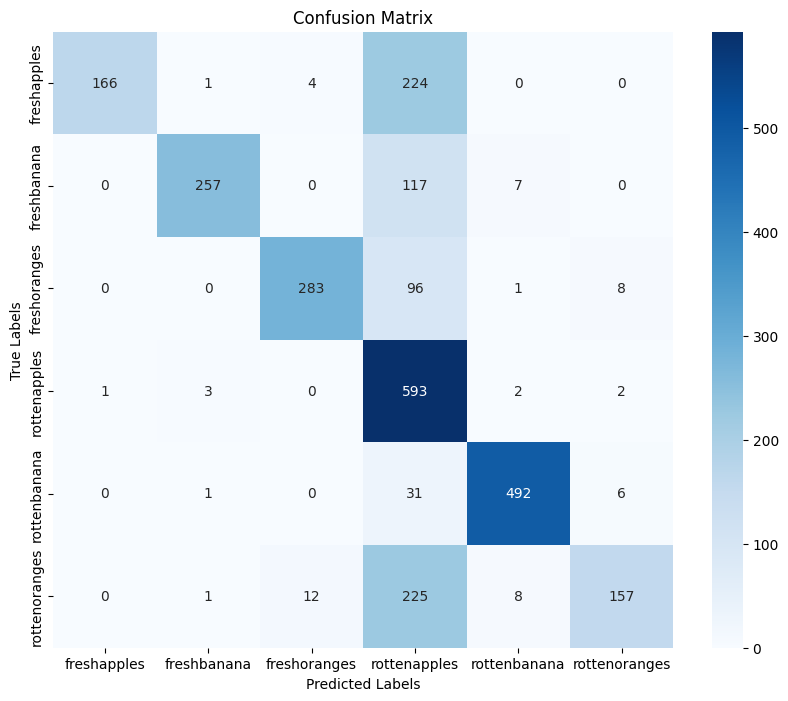

In [ ]:
# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=valid_it.class_indices.keys(), yticklabels=valid_it.class_indices.keys())
plt.title('DenseNet121 Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# Calcular e imprimir el informe de clasificación
class_report = classification_report(y_true, y_pred_classes, target_names=valid_it.class_indices.keys())
print("DenseNet121 Classification Report:")
print(class_report)

Classification Report:
               precision    recall  f1-score   support

  freshapples       0.99      0.42      0.59       395
  freshbanana       0.98      0.67      0.80       381
 freshoranges       0.95      0.73      0.82       388
 rottenapples       0.46      0.99      0.63       601
 rottenbanana       0.96      0.93      0.95       530
rottenoranges       0.91      0.39      0.55       403

     accuracy                           0.72      2698
    macro avg       0.88      0.69      0.72      2698
 weighted avg       0.85      0.72      0.72      2698



In [ ]:
import pickle
from google.colab import files

# Guarda el modelo entrenado en un archivo .pkl
with open('modelo_entrenado.pkl', 'wb') as f:
    pickle.dump(model, f)

# Descarga el archivo .pkl desde Google Colab
files.download('modelo_entrenado.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>